# Imports and constants

In [3]:
import subprocess
import os
import sys

PROJECT_ROOT = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()

bids_dir = os.path.join(PROJECT_ROOT, "data")
output_dir = os.path.join(PROJECT_ROOT, "output")
fs_license = os.path.join(PROJECT_ROOT, "license.txt")
work_dir = os.path.join(PROJECT_ROOT, "work")
subject = "101410"

#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
# import lmod
# await lmod.purge(force=True)
# await lmod.load('fsl/6.0.7.4')
# await lmod.load('freesurfer/7.4.1')
# await lmod.list()

from nilearn import plotting, image, datasets
from nilearn.maskers import NiftiLabelsMasker
from nilearn.image import math_img, concat_imgs, resample_to_img
from nipype.interfaces import fsl
from fsl.wrappers import fast, bet
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from nipype.interfaces.ants import N4BiasFieldCorrection
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
data_folder = 'data'
fmri_data_dir = os.path.join(data_folder, 'fMRI')
fmri_output_dir = os.path.join(output_dir, 'fmri')
smri_output_dir = os.path.join(output_dir, 'smri')
os.makedirs(fmri_output_dir, exist_ok=True)
os.makedirs(smri_output_dir, exist_ok=True)
os.makedirs(work_dir, exist_ok=True)

t1w_file = os.path.join(data_folder, 'T1w/T1w.nii.gz')

try:
    result = subprocess.run(['ls', '-R', bids_dir], 
                            capture_output=True, 
                            text=True, 
                            check=True)
    print(result.stdout)

except subprocess.CalledProcessError as e:
    print(f"Error checking directory: {e.stderr}")
except FileNotFoundError:
    print("Error: 'ls' command not found.")

T1w
dataset_description.json
dataset_description.md
fMRI
task-motor_bold.json

/Users/bui/code/NX-421-project/data/T1w:
T1w.nii.gz

/Users/bui/code/NX-421-project/data/fMRI:
tfMRI_MOTOR_LR
tfMRI_MOTOR_RL

/Users/bui/code/NX-421-project/data/fMRI/tfMRI_MOTOR_LR:
events_LR.csv
tfMRI_MOTOR_LR.nii

/Users/bui/code/NX-421-project/data/fMRI/tfMRI_MOTOR_RL:
events_RL.csv
tfMRI_MOTOR_RL.nii



# Structural preprocessing

## Original brain plot

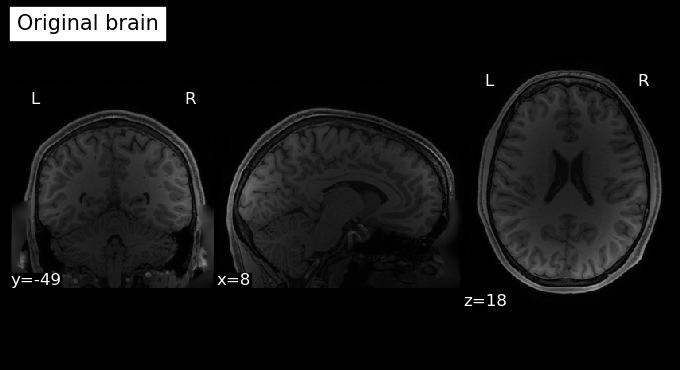

In [78]:
display = plotting.plot_anat(
    t1w_file,
    title='Original brain',
    display_mode='ortho',
    draw_cross=False,
)

plot_path = os.path.join(work_dir, 'original_brain_plot.png')
display.savefig(plot_path)
plotting.show()

### Using BET

In [56]:
out_1_default = os.path.join(smri_output_dir, 't1w_brain_1.nii.gz')
out_2_robust = os.path.join(smri_output_dir, 't1w_brain_2_robust.nii.gz')
out_3_generous = os.path.join(smri_output_dir, 't1w_brain_3_generous.nii.gz')
out_4_bias_correct = os.path.join(smri_output_dir, 't1w_brain_4_robust_bias.nii.gz')
out_5 = os.path.join(smri_output_dir, 't1w_brain_5.nii.gz')
out_6 = os.path.join(smri_output_dir, 't1w_brain_6.nii.gz')

# print("Running Command 1 (Default)...")
# !bet {t1w_file} {out_1_default} -f 0.5

# # Command 2: Robust mode (from your example)
# print("Running Command 2 (Robust)...")
# !bet {t1w_file} {out_2_robust} -f 0.5 -R

# # Command 3: Generous (larger) brain
# print("Running Command 3 (Generous)...")
# !bet {t1w_file} {out_3_generous} -f 0.2

# # Command 4: Robust + Bias Correction + Mask
# print("Running Command 4 (Robust, Bias-Corrected, Mask)...")
# !bet {t1w_file} {out_4_bias_correct} -f 0.3 -B -m

# print("Running Command 5")
# !bet {t1w_file} {out_5} -f 0.5 -g 0.1

# print("Running Command 6")
# !bet {t1w_file} {out_6} -f 0.5 -g 0.2

# out_7 = os.path.join(output_dir, 't1w_brain_7.nii.gz')
# !bet {t1w_file} {out_7} -f 0.3 -B -m

# Strip more from the top: use -g with positive value
# out_top_more = os.path.join(smri_output_dir, 't1w_brain_top_aggressive.nii.gz')
# !bet {t1w_file} {out_top_more} -f 0.6 -R -g 0.2

# More aggressive on the bottom: use -g with negative value  
# out_bottom_aggressive = os.path.join(smri_output_dir, 't1w_brain_bottom_aggressive.nii.gz')
# !bet {t1w_file} {out_bottom_aggressive} -f 0.6 -R -g -0.3

out_exp = os.path.join(smri_output_dir, 't1w_brain_exp.nii.gz')
# !bet {t1w_file} {out_exp} -f 0.5 -R
os.system(f'bet {t1w_file} {out_exp} -f 0.5 -R -m')

0

## Skull stripped brain plot

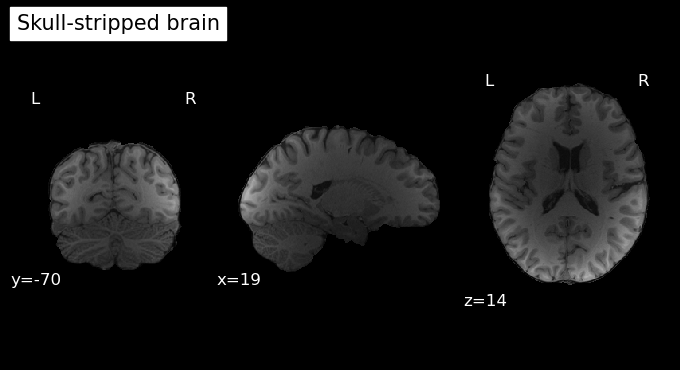

In [79]:
skull_stripped_file = os.path.join(smri_output_dir, 't1w_brain_exp.nii.gz')

display = plotting.plot_anat(
    skull_stripped_file,
    title='Skull-stripped brain',
    display_mode='ortho',
    draw_cross=False,
)

plot_path = os.path.join(work_dir, 'skull_stripped_brain_plot.png')
display.savefig(plot_path)
plotting.show()


## Segmentation

In [80]:
fast = fsl.FAST()
skull_stripped_file = os.path.join(smri_output_dir, 't1w_brain_exp.nii.gz')
# n4_corrected_file = os.path.join(smri_output_dir, 't1w_brain_exp_n4.nii.gz')

# print(f"Running N4 Bias Field Correction on: {skull_stripped_file}")
# print("This will create a new, cleaner T1w file...")

# n4 = N4BiasFieldCorrection()
# n4.inputs.input_image = skull_stripped_file
# n4.inputs.output_image = n4_corrected_file
# n4.inputs.dimension = 3
# n4.inputs.n_iterations = [50, 50, 30, 20] 
# n4.inputs.convergence_threshold = 1e-6
# n4.inputs.bspline_fitting_distance = 300

# n4_result = n4.run()

# print(f"N4 corrected file saved to: {n4_corrected_file}")

fast.inputs.in_files = skull_stripped_file
fast.inputs.img_type = 1
fast.inputs.number_classes = 3 # Segment into GM, WM, and CSF
fast.inputs.probability_maps = True
fast.inputs.output_type = 'NIFTI_GZ'
fast.inputs.hyper = 0.1
# fast.inputs.mixel_smooth = 0.1
fast.inputs.use_priors = False

print("Running FAST segmentation... Can take up to 5 minutes")
result = fast.run()
print("FAST segmentation finished.")

Running FAST segmentation... Can take up to 5 minutes
FAST segmentation finished.


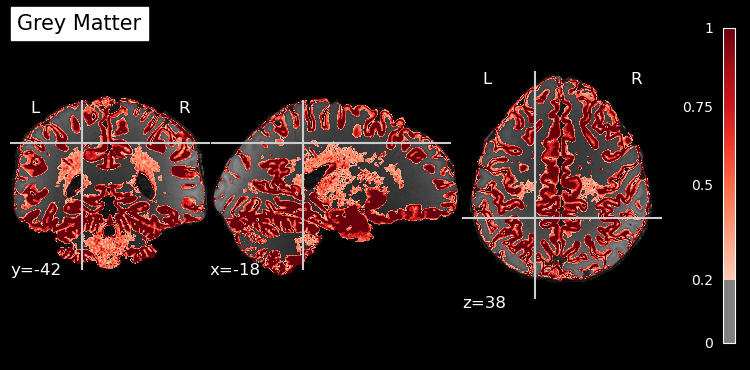

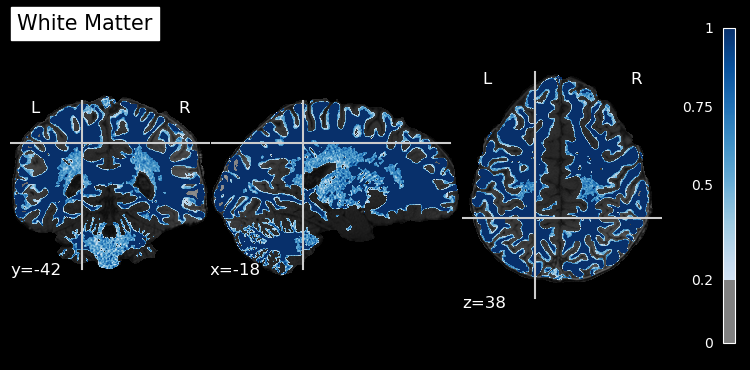

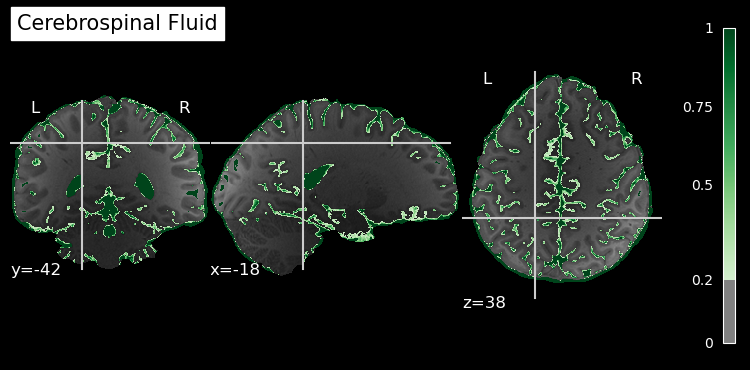

In [ ]:
skull_stripped_file = os.path.join(smri_output_dir, 't1w_brain_exp.nii.gz')
base_name = os.path.basename(skull_stripped_file).split('.')[0]

bg_img = image.load_img(skull_stripped_file)

csf_pve_file = os.path.join(smri_output_dir, f"{base_name}_pve_0.nii.gz")
gm_pve_file = os.path.join(smri_output_dir, f"{base_name}_pve_1.nii.gz")
wm_pve_file = os.path.join(smri_output_dir, f"{base_name}_pve_2.nii.gz")

csf_img = image.load_img(csf_pve_file)
gm_img = image.load_img(gm_pve_file)
wm_img = image.load_img(wm_pve_file)

seg_file = os.path.join(smri_output_dir, f"{base_name}_seg.nii.gz")
seg_img = image.load_img(seg_file)

cut_coords = (-18.53492, -42.50713, 38.89582)

plotting.plot_stat_map(gm_img,
                         bg_img=bg_img,
                         title='Grey Matter',
                         cut_coords=cut_coords,
                         display_mode='ortho',
                         cmap='Reds',
                         threshold=0.2) # Only show voxels > 20% probability

plotting.plot_stat_map(wm_img,
                         bg_img=bg_img,
                         title='White Matter',
                         cut_coords=cut_coords,
                         display_mode='ortho',
                         cmap='Blues',
                         threshold=0.2)     

plotting.plot_stat_map(csf_img,
                         bg_img=bg_img,
                         title='Cerebrospinal Fluid',
                         cut_coords=cut_coords,
                         display_mode='ortho',
                         cmap='Greens',
                         threshold=0.2)

custom_cmap = ListedColormap(['green', 'red', 'blue'])

plotting.plot_roi(seg_img,
                  bg_img=bg_img,
                  cut_coords=cut_coords,
                  display_mode='ortho',
                  annotate=True,
                  draw_cross=True,
                  cmap=custom_cmap,
                #   output_file=os.path.join(work_dir, f"{base_name}_seg_mid_slice.png") # only used if u wanna save
                  )

plotting.show()

# Functional preprocessing

## Concatenate all runs

In [38]:
# loading files

base_name = 't1w_brain_exp'
stripped_file = os.path.join(smri_output_dir, f"{base_name}.nii.gz")

mask_file_to_create = os.path.join(smri_output_dir, f"{base_name}_mask.nii.gz")
generous_img = image.load_img(stripped_file)
mask_img = math_img("img > 0", img=generous_img)
mask_img.to_filename(mask_file_to_create)

print(f"Mask file saved to: {mask_file_to_create}")

mask_file = mask_file_to_create

run_lr_file = os.path.join(fmri_data_dir, 'tfMRI_MOTOR_LR', 'tfMRI_MOTOR_LR.nii')
run_rl_file = os.path.join(fmri_data_dir, 'tfMRI_MOTOR_RL', 'tfMRI_MOTOR_RL.nii')

concatenated_file = os.path.join(fmri_output_dir, 'tfMRI_MOTOR_concatenated.nii.gz')

Mask file saved to: /Users/bui/code/NX-421-project/output/smri/t1w_brain_exp_mask.nii.gz


In [ ]:
def scale_run(fmri_file):    
    fmri_img = image.load_img(fmri_file)
    fmri_data = fmri_img.get_fdata()
    
    global_std = np.std(fmri_data, ddof=1) 
    scaled_img = math_img(f"img / {global_std}", img=fmri_img)
    
    return scaled_img

scaled_lr_img = scale_run(run_lr_file)
scaled_rl_img = scale_run(run_rl_file)

concatenated_img = concat_imgs([scaled_lr_img, scaled_rl_img])
concatenated_img.to_filename(concatenated_file)

print(f"Concatenated file saved to: {concatenated_file}")
print(f"  ...Original shape (LR): {scaled_lr_img.shape}")
print(f"  ...Original shape (RL): {scaled_rl_img.shape}")
print(f"  ...New concatenated shape: {concatenated_img.shape}")

  ...Global STD found: 4663.2075
  ...Global STD found: 4648.6623
Concatenated file saved to: /Users/bui/code/NX-421-project/output/fmri/tfMRI_MOTOR_concatenated.nii.gz
  ...Original shape (LR): (91, 109, 91, 284)
  ...Original shape (RL): (91, 109, 91, 284)
  ...New concatenated shape: (91, 109, 91, 568)


## Motion Correction

In [42]:
concatenated_file = os.path.join(fmri_output_dir, 'tfMRI_MOTOR_concatenated.nii.gz')

mc_file = os.path.join(fmri_output_dir, 'tfMRI_MOTOR_mc')

mcflirt = fsl.MCFLIRT()
mcflirt.inputs.in_file = concatenated_file
mcflirt.inputs.out_file = mc_file 
mcflirt.inputs.save_plots = True
mcflirt.inputs.mean_vol = True
mcflirt.inputs.stats_imgs = True

try:
    print("Running motion correction (takes around 2-3 min)...")
    result = mcflirt.run()
    mc_file = result.outputs.out_file
    param_file = result.outputs.par_file
    print("Motion correction finished (Nipype successful).")

except FileNotFoundError as e:
    print(f"\n--- Nipype bug encountered ---")
    print(f"Error: {e}")
    print("Ignoring error bcs FSL has a freaking bug")
    
    param_file = mc_file + ".par"
    mc_file = mc_file + ".nii.gz"
    
    if not os.path.exists(mc_file) or not os.path.exists(param_file):
        print("\n---!!! FATAL ERROR !!!---")
        print(f"FSL files not found at: \n{mc_file}\n{param_file}")
        print("The FSL command *actually* failed. Check FSL installation.")
    else:
        print("Motion correction finished (files found manually).")

print(f"\nMotion file created at: {mc_file}")
print(f"Motion parameters saved to: {param_file}")

Running motion correction (takes around 2-3 min)...

--- Nipype bug encountered ---
Error: No such file or directory '/Users/bui/code/NX-421-project/output/fmri/tfMRI_MOTOR_mc' for output 'out_file' of a MCFLIRT interface
Ignoring error bcs FSL has a freaking bug
Motion correction finished (files found manually).

Motion file created at: /Users/bui/code/NX-421-project/output/fmri/tfMRI_MOTOR_mc.nii.gz
Motion parameters saved to: /Users/bui/code/NX-421-project/output/fmri/tfMRI_MOTOR_mc.par


In [43]:
mc_file = os.path.join(fmri_output_dir, 'tfMRI_MOTOR_mc.nii.gz')
param_file = os.path.join(fmri_output_dir, 'tfMRI_MOTOR_mc.par')

Plotting FD...


/var/folders/gs/vcnb5f6s7fj7nkdhj2hwrrmr0000gn/T/ipykernel_79535/3325960895.py:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  mot_params_df = pd.read_csv(param_file, sep='  ', header=None,


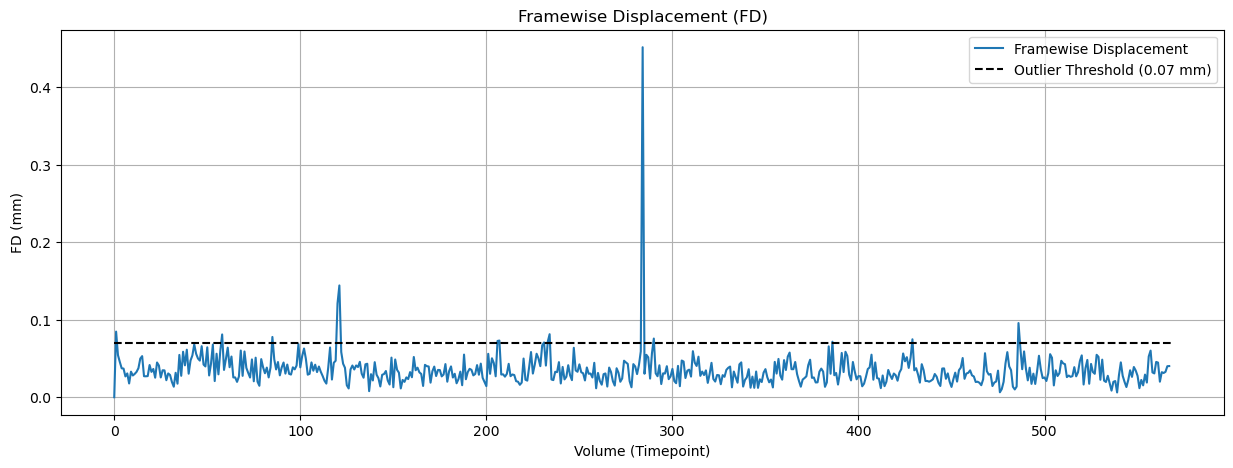

Max FD: 0.4517 mm
Mean FD: 0.0348 mm
Volumes exceeding threshold (FD > 0.07 mm): 15


In [44]:
def compute_FD_power(mot_params_df):
    """Calculates FD from a DataFrame (assumes rotations are in RADIANS)"""
    framewise_diff = mot_params_df.diff().iloc[1:]
    
    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Convert radians to mm on a 50mm radius sphere
    converted_rots = rot_params * 50
    
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    
    # Sum the absolute values (L1 norm)
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd.to_numpy()

mot_params_df = pd.read_csv(param_file, sep='  ', header=None,
                            names=['Rotation x', 'Rotation y', 'Rotation z', 
                                   'Translation x', 'Translation y', 'Translation z'])

fd = compute_FD_power(mot_params_df)
fd = np.insert(fd, 0, 0)

print("Plotting FD...")

q75, q25 = np.quantile(fd, [0.75, 0.25])
iqr = q75 - q25
threshold = q75 + 1.5 * iqr

plt.figure(figsize=(15, 5))
plt.plot(fd, label='Framewise Displacement')
plt.hlines(threshold, 0, len(fd), colors='black', linestyles='dashed', label=f'Outlier Threshold ({threshold:.2f} mm)')
plt.title('Framewise Displacement (FD)')
plt.xlabel('Volume (Timepoint)')
plt.ylabel('FD (mm)')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(work_dir, 'fd_plot.png'))
plt.show()

print(f"Max FD: {np.max(fd):.4f} mm")
print(f"Mean FD: {np.mean(fd):.4f} mm")
print(f"Volumes exceeding threshold (FD > {threshold:.2f} mm): {np.sum(fd > threshold)}")

In [46]:
bad_frames = (np.where(fd > threshold)[0] + 1).tolist()
print(f"Indices of frames above threshold(total: {len(bad_frames)}): {bad_frames}")

Indices of frames above threshold(total: 15): [2, 59, 86, 121, 122, 207, 208, 232, 234, 235, 285, 291, 387, 430, 487]


## Coregistration (BONUS)
How the code works: epi_reg calls FAST on the T1 brain-extracted image to obtain a white-matter probability map. It then performs boundary-based registration (BBR),i.e. it aligns the EPI to the T1 by maximizing the intensity gradient at WM/GM boundaries (uses FSL FLIRT)

In [81]:
print("running... takes about 5-10 mins")
t1w_file = os.path.join(data_folder, 'T1w', 'T1w.nii.gz')
t1_brain = os.path.join(smri_output_dir, 't1w_brain_exp.nii.gz') 
mc_file = mc_file = os.path.join(fmri_output_dir, 'tfMRI_MOTOR_mc.nii.gz')

mean_fmri = os.path.join(fmri_output_dir, 'tfMRI_MOTOR_mc_mean.nii.gz') 
epi2t1_mat = os.path.join(fmri_output_dir, 'epi2t1.mat')
fmri_in_t1 = os.path.join(fmri_output_dir, 'tfMRI_MOTOR_mc_in_T1.nii.gz')

subprocess.run(['fslmaths', mc_file, '-Tmean', mean_fmri], check=True)

out_base = os.path.join(fmri_output_dir, 'epi2t1')
cmd = (
    f'epi_reg --epi="{mean_fmri}" '
    f'--t1="{t1w_file}" '
    f'--t1brain="{t1_brain}" '
    f'--out="{out_base}"'
)

subprocess.run(["bash", "-lc", cmd], check=True)
epi2t1_img = out_base + ".nii.gz"
epi2t1_mat = out_base + ".mat"

running... takes about 5-10 mins
Running FAST segmentation
FLIRT pre-alignment
Running BBR
0.963116 0.999707 0.023822 -0.004218 0.000000 -0.023849 0.999694 -0.006629 0.000000 0.004058 0.006728 0.999969 0.000000 2.386905 3.320971 3.511019 1.000000 


In [ ]:
#Apply transform to the full 4D series (uncomment to run if you have a spare 20 minutes; not necessary)
'''
subprocess.run([
    'applyxfm4D',
    mc_file,          
    t1_brain,        
    fmri_in_t1,     
    epi2t1_mat,      
    '-interp', 'trilinear',
    '-singlematrix'   
], check=True)
'''

/var/folders/gs/vcnb5f6s7fj7nkdhj2hwrrmr0000gn/T/ipykernel_79535/2120614602.py:4: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  t1_res = resample_to_img(t1, epi_in_t1, interpolation='linear')
/Users/bui/anaconda3/envs/NX-421/lib/python3.12/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


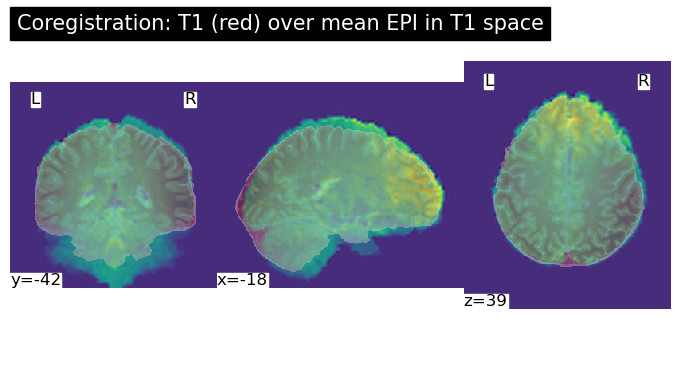

In [82]:
epi2t1_img_path = os.path.join(fmri_output_dir, 'epi2t1.nii.gz')
t1 = image.load_img(t1_brain)       
epi_in_t1 = image.load_img(epi2t1_img_path)    
t1_res = resample_to_img(t1, epi_in_t1, interpolation='linear')
cut_coords = (-18, -42, 39)
disp = plotting.plot_img(
    epi_in_t1,
    display_mode='ortho',
    cut_coords=cut_coords,
    draw_cross=False,
    title='Coregistration: T1 (red) over mean EPI in T1 space'
)
disp.add_overlay(t1_res, cmap='Reds', alpha=0.35)
plotting.show()

## Gaussian smoothing

In [47]:
mc_file = os.path.join(fmri_output_dir, 'tfMRI_MOTOR_mc.nii.gz')
voxel_dimensions = image.load_img(mc_file).header.get_zooms()[:3]

print(f"The voxel size of your fMRI data is: {voxel_dimensions} mm")

The voxel size of your fMRI data is: (np.float32(2.0), np.float32(2.0), np.float32(2.0)) mm



Running Gaussian smoothing with a 6.0mm FWHM... (takes about 1 minute)
Smoothed file saved to: /Users/bui/code/NX-421-project/output/fmri/tfMRI_MOTOR_smooth.nii.gz


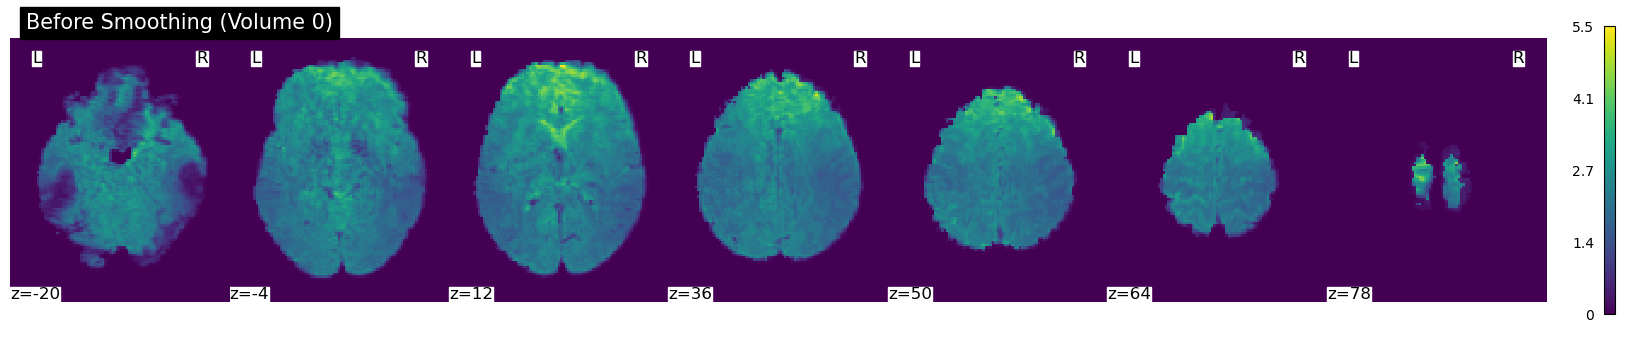

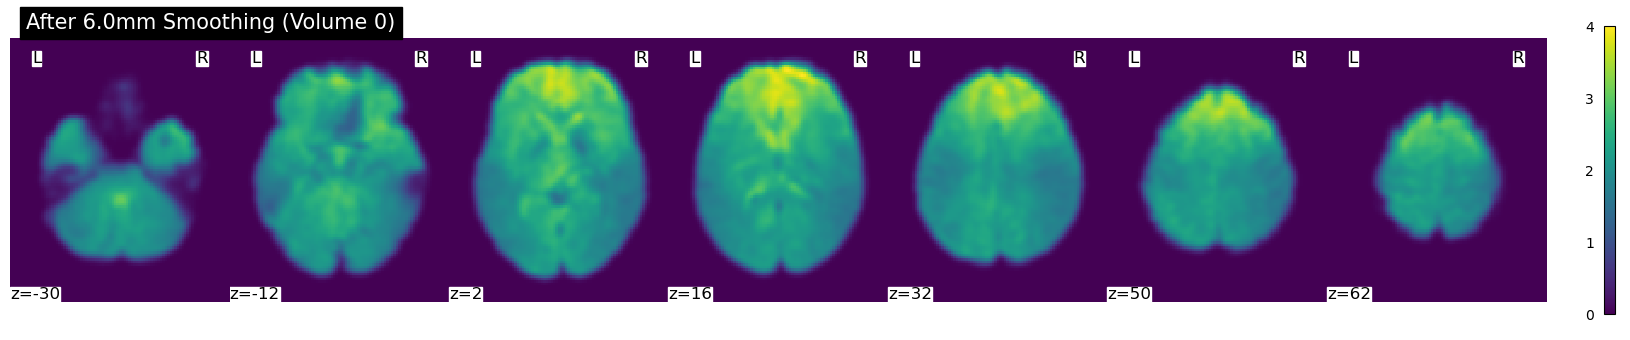

In [160]:
smooth_file = os.path.join(fmri_output_dir, 'tfMRI_MOTOR_smooth.nii.gz')
mc_img = image.load_img(mc_file)

vol_0_before = image.index_img(mc_img, 0)
plotting.plot_img(vol_0_before,
                  title="Before Smoothing (Volume 0)",
                  display_mode='z',
                  colorbar=True,
                  annotate=True,
                  draw_cross=True,
                #   output_file=os.path.join(work_dir, 'vol_0_before_smoothing.png')
)

fwhm = 6.0 
print(f"\nRunning Gaussian smoothing with a {fwhm}mm FWHM... (takes about 1 minute)")

smooth_img = image.smooth_img(mc_img, fwhm=fwhm)
smooth_img.to_filename(smooth_file)
print(f"Smoothed file saved to: {smooth_file}")

vol_0_after = image.index_img(smooth_img, 0)
plotting.plot_img(vol_0_after,
                  title=f"After {fwhm}mm Smoothing (Volume 0)",
                  display_mode='z',
                  colorbar=True,
                  annotate=True,
                  draw_cross=True,
                #   output_file=os.path.join(work_dir, 'vol_0_after_smoothing.png')
                  )

plotting.show()

## GLM

### Design matrix

In [51]:
param_file = os.path.join(fmri_output_dir, 'tfMRI_MOTOR_mc.par')
events_lr_file = os.path.join(fmri_data_dir, 'tfMRI_MOTOR_LR', 'events_LR.csv')
events_rl_file = os.path.join(fmri_data_dir, 'tfMRI_MOTOR_RL', 'events_RL.csv')

tr = 0.72 # from json
n_volumes_run1 = 284
n_volumes_run2 = 284
n_volumes_total = n_volumes_run1 + n_volumes_run2
frame_times = np.arange(n_volumes_total) * tr

events_lr = pd.read_csv(events_lr_file, sep=',')
events_rl = pd.read_csv(events_rl_file, sep=',')

print("Columns in events_LR.csv:", events_lr.columns)
print("Columns in events_RL.csv:", events_rl.columns)

print("Offsetting onsets for Run 2...")
duration_run1_sec = n_volumes_run1 * tr
events_rl['onset'] = events_rl['onset'] + duration_run1_sec

print("Concatenating event files...")
events_df = pd.concat([events_lr, events_rl]).reset_index(drop=True)
events_df.rename(columns={'condition': 'trial_type'}, inplace=True)
events_df['trial_type'] = events_df['trial_type'].fillna('start')

print("Combined events dataframe (first 5 rows):")
print(events_df)

print(f"\nLoading motion parameters from: {param_file}")

motion_params = pd.read_csv(param_file, sep='  ', header=None, engine='python',
                            names=['rot_x', 'rot_y', 'rot_z', 
                                   'trans_x', 'trans_y', 'trans_z'])

# here we incoporate motion correction
outlier_indices = np.where(fd > threshold)[0] # dont add 1 since we already have 0th frame
print(f"total number of outliers: {len(outlier_indices)}")
spike_regs = np.zeros((len(fd), len(outlier_indices)))
for i, idx in enumerate(outlier_indices):
    spike_regs[idx, i] = 1

spike_df = pd.DataFrame(
    spike_regs,
    columns=[f'spike_{idx}' for idx in outlier_indices]
)
all_nuisance_regs = pd.concat([motion_params, spike_df], axis=1)

print(f"Motion parameters shape: {all_nuisance_regs.shape}")

all_nuisance_regs.head()

Columns in events_LR.csv: Index(['onset', 'duration', 'condition'], dtype='object')
Columns in events_RL.csv: Index(['onset', 'duration', 'condition'], dtype='object')
Offsetting onsets for Run 2...
Concatenating event files...
Combined events dataframe (first 5 rows):
     onset  duration trial_type
0     0.00       8.0      start
1     8.00       3.0        cue
2    11.00      12.0         rh
3    23.00       3.0        cue
4    26.00      12.0         lf
5    38.00       3.0        cue
6    41.00      12.0          t
7    53.00       3.0        cue
8    56.00      12.0         rf
9    68.00       3.0        cue
10   71.00      12.0         lh
11   83.00      15.0   fixation
12   98.00       3.0        cue
13  101.00      12.0          t
14  113.00       3.0        cue
15  116.00      12.0         lf
16  128.00       3.0        cue
17  131.00      12.0         rh
18  143.00      16.0   fixation
19  159.00       3.0        cue
20  162.00      12.0         lh
21  174.00       3.0      

,rot_x,rot_y,rot_z,trans_x,trans_y,trans_z,spike_1,spike_58,spike_85,spike_120,...,spike_206,spike_207,spike_231,spike_233,spike_234,spike_284,spike_290,spike_386,spike_429,spike_486
0,0.000640,-0.006584,-0.002342,-0.365896,-0.238620,0.204367,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000608,-0.005764,-0.002173,-0.372141,-0.240056,0.230408,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000723,-0.006261,-0.002296,-0.374971,-0.227593,0.228026,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.001010,-0.006076,-0.002181,-0.369949,-0.232119,0.234551,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000855,-0.006337,-0.002121,-0.372363,-0.232039,0.223519,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Plotting design matrix...


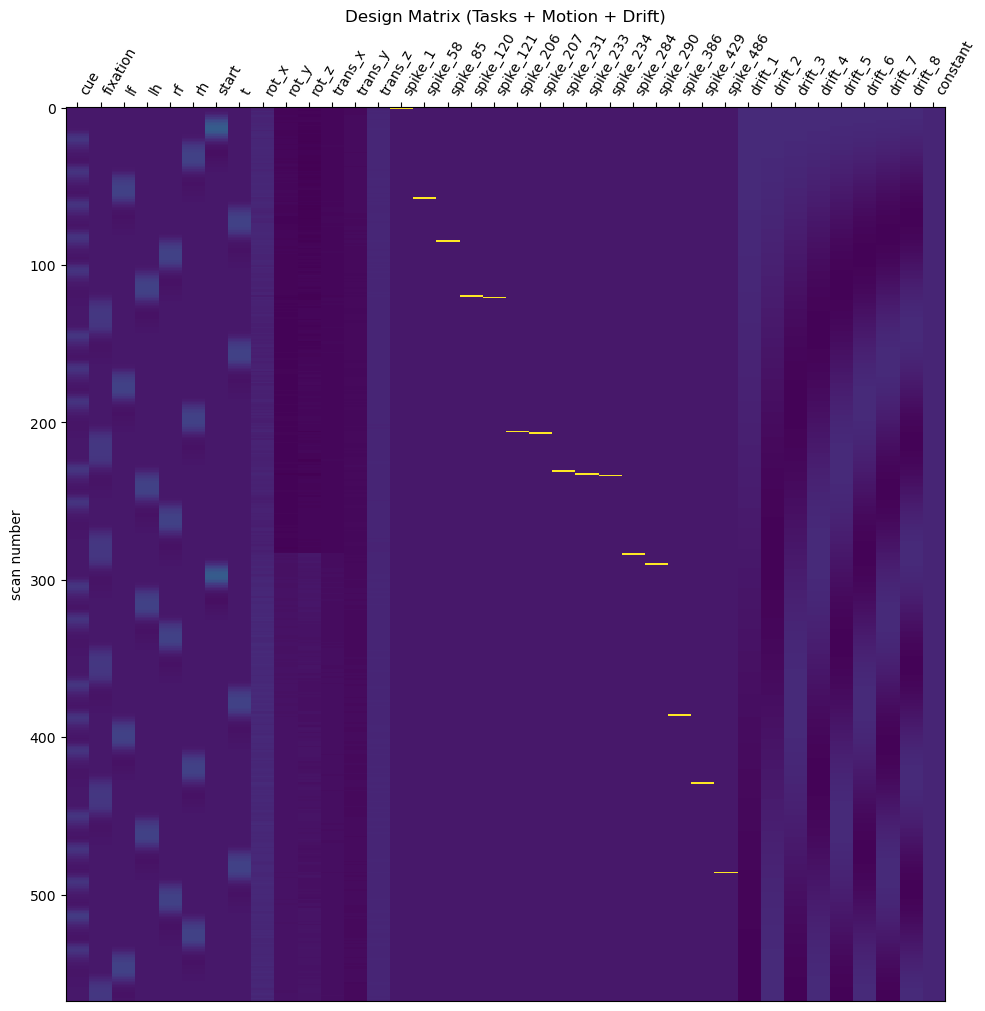

(568, 38)


In [52]:
design_matrix = make_first_level_design_matrix(
    frame_times,           # The 568 scan times in seconds
    events=events_df,      # The combined events (onset, duration, condition)
    hrf_model='spm',    # Use the 'glover' HRF (or 'spm')
    drift_model='cosine',  # Models scanner drift
    high_pass=0.01,        # Standard high-pass filter cutoff (1/100s)
    add_regs=all_nuisance_regs # Add our 6 motion columns
)

print("Plotting design matrix...")

plotting.plot_design_matrix(design_matrix)
plt.savefig(os.path.join(work_dir, 'design_matrix.png'))

plt.title('Design Matrix (Tasks + Motion + Drift)')
plt.show()

print(design_matrix.shape)

### Fit GLM

In [53]:
fmri_model = FirstLevelModel(
    t_r=tr,
    hrf_model='spm',
    drift_model='cosine',
    high_pass=0.01,
    noise_model='ar1'
)

fmri_model = fmri_model.fit(run_imgs=smooth_file,
                            design_matrices=design_matrix)

### Stat map of all tasks

In [55]:
task_regressors = ['lf', 'rf', 'lh', 'rh', 't'] 
mean_img_file = os.path.join(fmri_output_dir, 'tfMRI_MOTOR_mc_meanvol.nii.gz')
mean_img = image.load_img(mean_img_file)

cut_cords= (-10, -20, 65)
for task in task_regressors:
    chosen_baseline = 'fixation'    
    contrast_def = f"{task} - {chosen_baseline}"
    z_map = fmri_model.compute_contrast(contrast_def, output_type='z_score')
    
    plotting.plot_stat_map(
        z_map,
        bg_img=mean_img,
        threshold=3.1,
        title=f"{task} (vs. {chosen_baseline})",
        display_mode='ortho',
        cut_coords=cut_cords,
        output_file=os.path.join(work_dir, f"{task}_vs_{chosen_baseline}.png")
    )

plotting.show()

### Hand motion against feet motion

Computing and plotting statistical maps for each task...


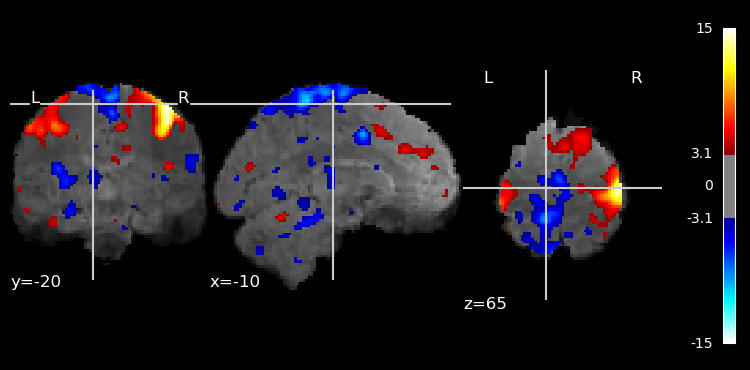

In [70]:
print("Computing and plotting statistical maps for each task...")

task_regressors = ['lf', 'rf', 'lh', 'rh', 't']
mean_img_file = os.path.join(fmri_output_dir, 'tfMRI_MOTOR_mc_meanvol.nii.gz')
mean_img = image.load_img(mean_img_file)

cut_coords = (-36, -30, 60)
contrast_def = 'lh + rh - lf - rf'
z_map = fmri_model.compute_contrast(contrast_def, output_type='z_score')
z_map.to_filename(os.path.join(fmri_output_dir, 'hand_vs_feet.nii.gz'))
plotting.plot_stat_map(
    z_map,
    bg_img=mean_img,
    threshold=3.1, 
    display_mode='ortho',
    cut_coords=cut_cords,
    # output_file=os.path.join(work_dir, 'hand_vs_feet.png')
)

plotting.show()

### Compare to AAL atlas parcellation

[get_dataset_dir] Dataset found in /Users/bui/nilearn_data/aal_SPM12

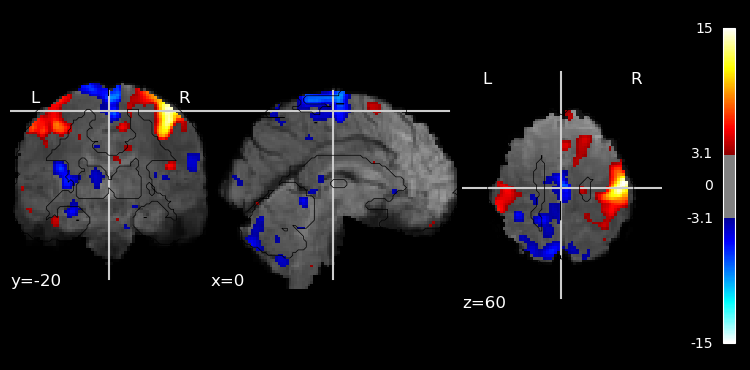

  Region with highest 'Hands > Feet' activity: Precentral_R
  (Index: 1, Mean z-score: 2.28)

  Region with highest 'Feet > Hands' activity: Paracentral_Lobule_L
  (Index: 68, Mean z-score: -3.88)


In [144]:
cleaned_map = image.load_img(os.path.join(fmri_output_dir, 'hand_vs_feet.nii.gz'))
aal = datasets.fetch_atlas_aal()

cut_coords = (0, -20, 60)
display = plotting.plot_stat_map(
    cleaned_map,
    bg_img=mean_img,
    threshold=3.1,
    display_mode='ortho',
    cut_coords=cut_coords
)

display.add_contours(aal.maps, levels=[0.5], colors='black', linewidths=0.5)
display.savefig(os.path.join(work_dir, 'hand_vs_feet_aal_overlay.png'))
plotting.show()

aal_masker = NiftiLabelsMasker(
    labels_img=aal.maps,
    standardize=False,
    strategy='mean' 
)

region_mean_scores = aal_masker.fit_transform(cleaned_map)[0]
peak_index = np.argmax(region_mean_scores)
peak_name = aal.labels[peak_index]
peak_score = region_mean_scores[peak_index]

print(f"  Region with highest 'Hands > Feet' activity: {peak_name}")
print(f"  (Index: {peak_index}, Mean z-score: {peak_score:.2f})")

min_index = np.argmin(region_mean_scores)
min_name = aal.labels[min_index]
min_score = region_mean_scores[min_index]

print(f"\n  Region with highest 'Feet > Hands' activity: {min_name}")
print(f"  (Index: {min_index}, Mean z-score: {min_score:.2f})")

## PCA

In [5]:
pca_data_dir = os.path.join(output_dir, 'fmri')
os.makedirs(pca_data_dir, exist_ok=True)

PCA_file = os.path.join(pca_data_dir, 'tfMRI_MOTOR_smooth.nii.gz')

fmri_data_pca = nib.load(PCA_file)
affine = fmri_data_pca.affine
data_pca = np.asanyarray(fmri_data_pca.dataobj)

print(f"Data shape: {data_pca.shape}")

Data shape: (91, 109, 91, 568)


### Mean centering

In [6]:
vol_shape = data_pca.shape[:-1]
n_vols = data_pca.shape[-1]

slice_non_background = data_pca[:,:,:,0] != 0
samples = data_pca[slice_non_background]

spatial_means = np.mean(samples, axis=1)
row_means = np.outer(spatial_means, np.ones(n_vols))
X = samples - row_means
X = X.T

X_scaled = StandardScaler().fit_transform(X)
print(X_scaled.shape)

(568, 432675)


### Performing PCA

In [7]:
nb_components = 20
pca = PCA(n_components=nb_components)
pca.fit(X_scaled)

print(f"PCA fitted with {pca.n_components_} components")


PCA fitted with 20 components


Cumulative variance explained by the first 2 components: 76.10%


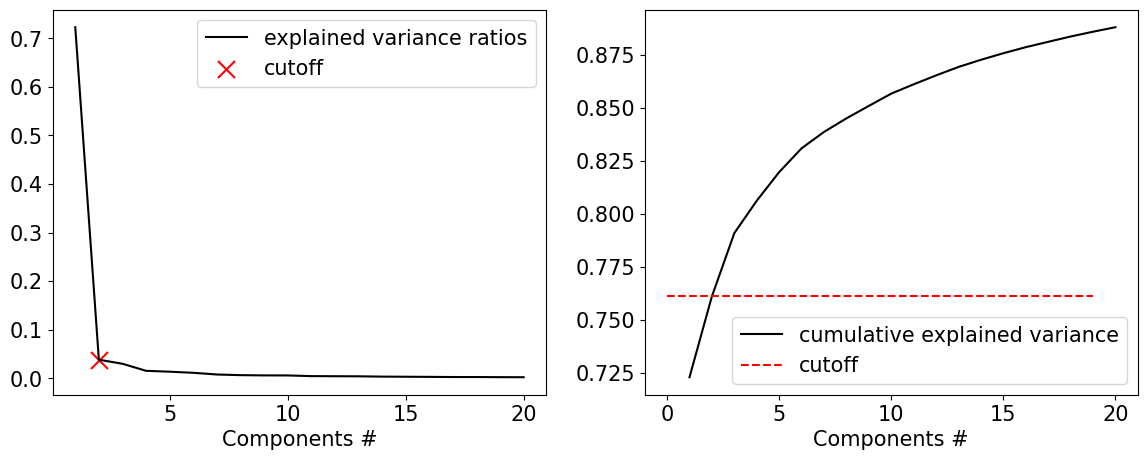

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

ratios = pca.explained_variance_ratio_
cumulative_ratios = np.cumsum(pca.explained_variance_ratio_)
nb_clusters = 2

cutoff_variance = cumulative_ratios[nb_clusters - 1] 
print(f"Cumulative variance explained by the first {nb_clusters} components: {cutoff_variance * 100:.2f}%")

ax[0].plot(np.arange(1, len(ratios)+1), ratios, label='explained variance ratios', c='k')
ax[0].scatter([nb_clusters], [ratios[nb_clusters-1]], [150], marker='x', color='r', label='cutoff')
ax[1].plot(np.arange(1, len(cumulative_ratios)+1), cumulative_ratios, label='cumulative explained variance', c='k')
ax[1].hlines(y=cumulative_ratios[nb_clusters-1], xmin=0, xmax=len(ratios)-1, linestyle='--', color='r', label='cutoff')

for k in range(2):
    ax[k].set_xlabel('Components #', size=15)
    ax[k].legend(prop={'size':15})
    ax[k].tick_params(axis='both', which='major', labelsize=15)

plt.show()


In [9]:
pca_clusters = []
for cluster_idx in range(nb_components):
    pca_component = np.zeros(vol_shape)
    pca_component[slice_non_background] = pca.components_[cluster_idx]
    pca_clusters.append(pca_component)

print(f"Created {len(pca_clusters)} PCA spatial components")


Created 20 PCA spatial components


### Axial view of first 2 components

/var/folders/gs/vcnb5f6s7fj7nkdhj2hwrrmr0000gn/T/ipykernel_71503/3351372682.py:1: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mean_img_ = image.mean_img(fmri_data_pca)


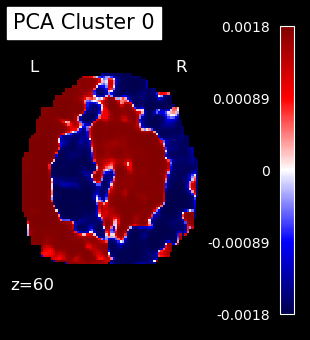

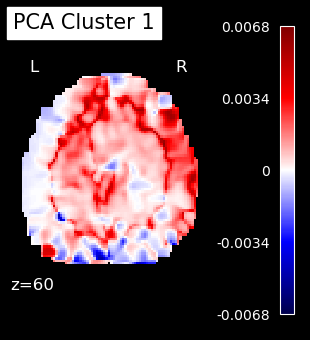

In [10]:
mean_img_ = image.mean_img(fmri_data_pca)

for visual_idx in range(nb_clusters):
    plotting.plot_stat_map(
        nib.Nifti1Image(pca_clusters[visual_idx], affine), 
        bg_img=mean_img_, 
        threshold=0,
        display_mode='z',
        cut_coords=[60],
        black_bg=True, 
        cmap="seismic",
        title=f'PCA Cluster {visual_idx}',
        # output_file=os.path.join(work_dir, f'pca_cluster_{visual_idx}.png')
    )
    plt.show()

### View first 10 components

/var/folders/gs/vcnb5f6s7fj7nkdhj2hwrrmr0000gn/T/ipykernel_71503/3250779097.py:1: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mean_img_ = image.mean_img(fmri_data_pca)


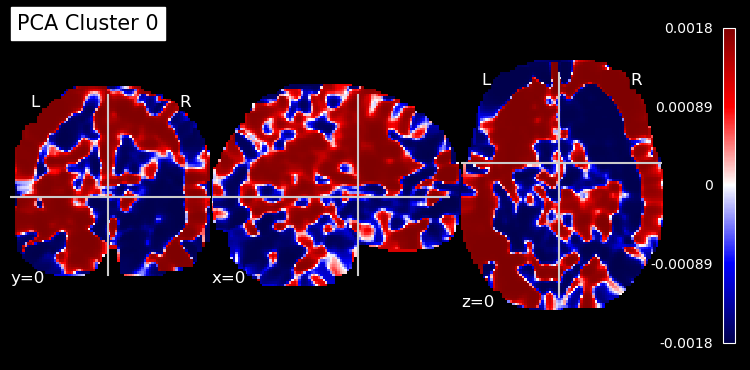

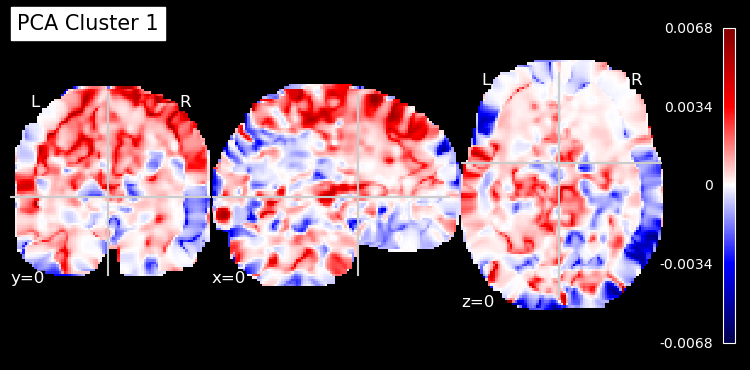

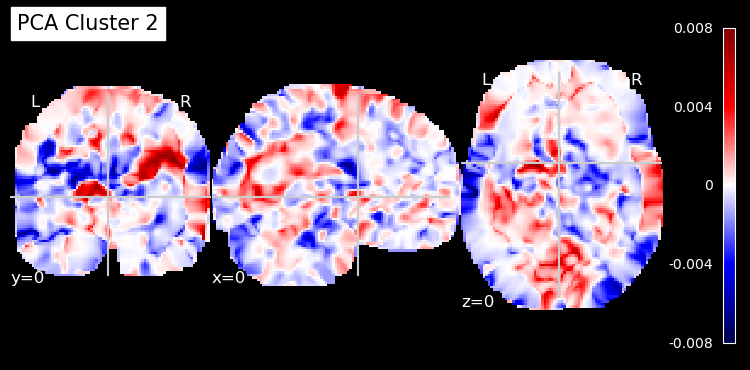

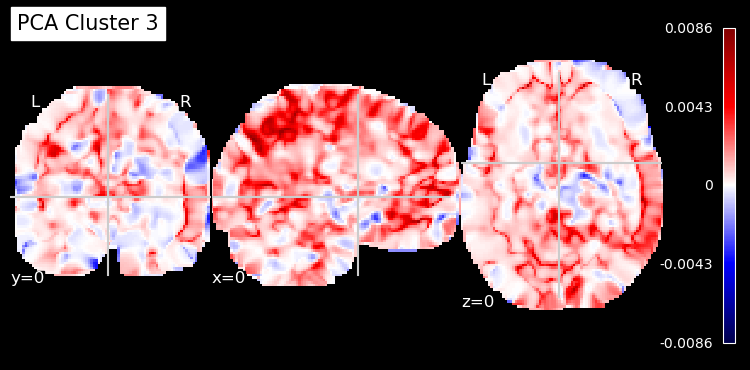

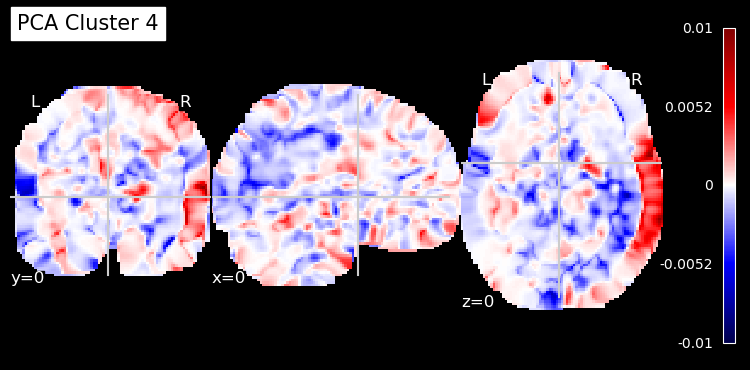

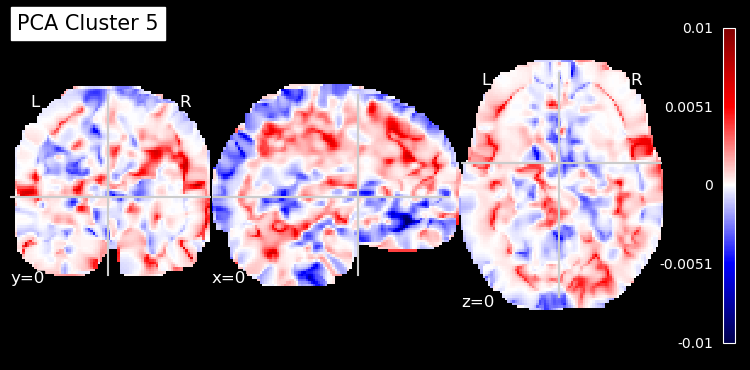

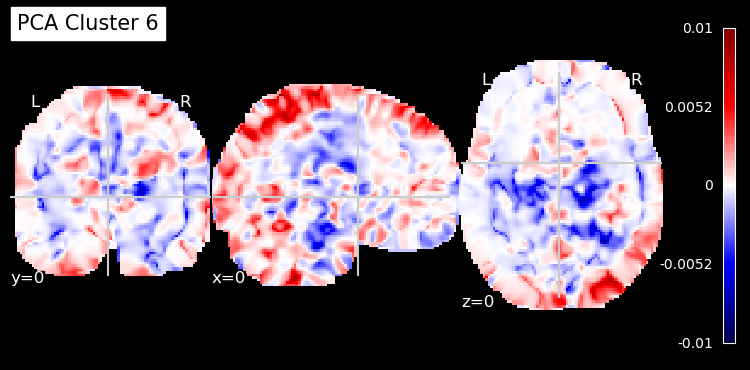

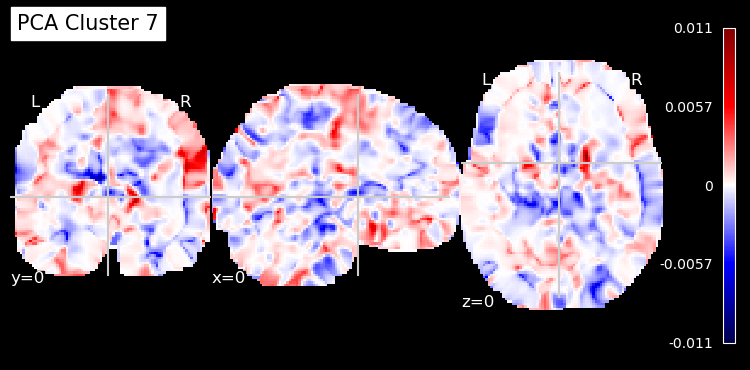

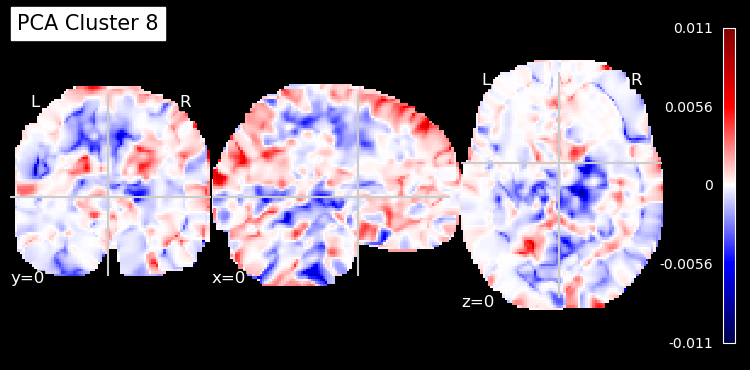

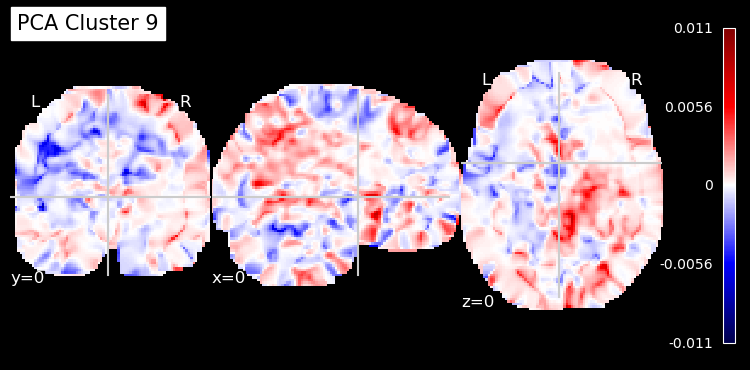

In [11]:
mean_img_ = image.mean_img(fmri_data_pca)

for visual_idx in range(10):
    plotting.plot_stat_map(nib.Nifti1Image(pca_clusters[visual_idx], affine), 
                  bg_img=mean_img_, 
                  threshold=0,
                  cut_coords=[0,0,0], 
                  black_bg=True, 
                  cmap="seismic",
                  title=f'PCA Cluster {visual_idx}',
                #   output_file=os.path.join(work_dir, f'pca_cluster_{visual_idx}.png')
                  )
    plt.show()


### Pairwise similarity

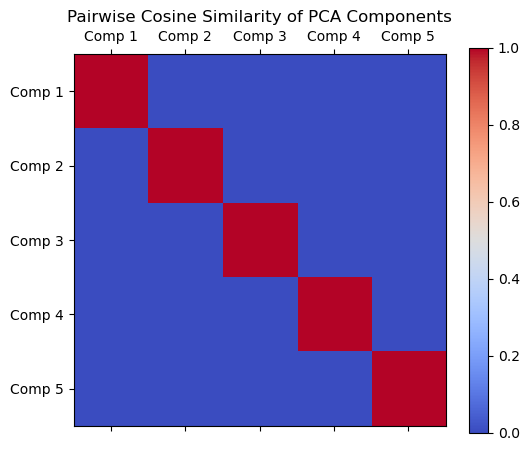

Pairwise Similarity Matrix:
[[ 1.00000000e+00 -6.18298053e-17  4.71187488e-17  1.54274346e-16
  -2.71968515e-17]
 [-6.18298053e-17  1.00000000e+00  7.97536577e-17 -8.75801363e-17
  -2.33557821e-17]
 [ 4.71187488e-17  7.97536577e-17  1.00000000e+00 -1.04733930e-16
  -4.53437912e-18]
 [ 1.54274346e-16 -8.75801363e-17 -1.04733930e-16  1.00000000e+00
   4.10573598e-16]
 [-2.71968515e-17 -2.33557821e-17 -4.53437912e-18  4.10573598e-16
   1.00000000e+00]]


In [140]:
pca_components = pca.components_
pca_subset_reshaped = pca_components[:5,]

similarity_matrix = cosine_similarity(pca_subset_reshaped)

fig, ax = plt.subplots(figsize=(6, 5))
cax = ax.matshow(similarity_matrix, cmap='coolwarm')
fig.colorbar(cax)
ax.set_xticks(np.arange(5))
ax.set_yticks(np.arange(5))
ax.set_xticklabels([f'Comp {i+1}' for i in range(5)])
ax.set_yticklabels([f'Comp {i+1}' for i in range(5)])

plt.title('Pairwise Cosine Similarity of PCA Components')
plt.savefig(os.path.join(work_dir, 'pca_similarity.png'))
plt.show()

print("Pairwise Similarity Matrix:")
print(similarity_matrix)
